# 2025.08.20

## Goals
- [ ] Simulate point source test problem (Q volume rate as gaussian, volume as step function)
- [ ] Validate Lighthill surface intergral implementation with test problem

## 1.0 Test problem
Define a guassian Q volume rate. Volume rate is then a step function. 

$$ 
\begin{align}
p(r, t) &= \frac{\rho \dot{Q}(t-r/c)}{4 \pi r} \\
v_r(r, t) &= \frac{Q(t-\frac{r}{c})}{4 \pi r^2} + \frac{\dot{Q}(t - \frac{r}{c})}{ 4 \pi r c}
\end{align}
$$


In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np 

def Q(t, sigma=0.5, mu=3, magnitude=1e2):
    return magnitude / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * (t - mu)**2 / sigma)

def Q_dot(t, sigma=0.1, mu=3):
    return - (t - mu) /sigma**2 *  Q(t, sigma)

def test_pressure(t, r, z, c=300, rho_0=10):
    return rho_0 * Q_dot(t - r/c) / (4 * np.pi * r)

def test_sigma(t, r, z, c=300, rho_0=10):
    return np.eye(2) * test_pressure(t, r, z, c, rho_0)

def test_velocity(t, r, z, c=300):
    v_radial = Q(t - r/c) / (4 * np.pi * r**2) + Q_dot(t - r/c) / (4 * np.pi * r * c)

    norm_rz = np.array([r, z])/np.linalg.norm([r,z])

    return v_radial[:, np.newaxis] * norm_rz

def test_rho(t, r, z):
    return 10

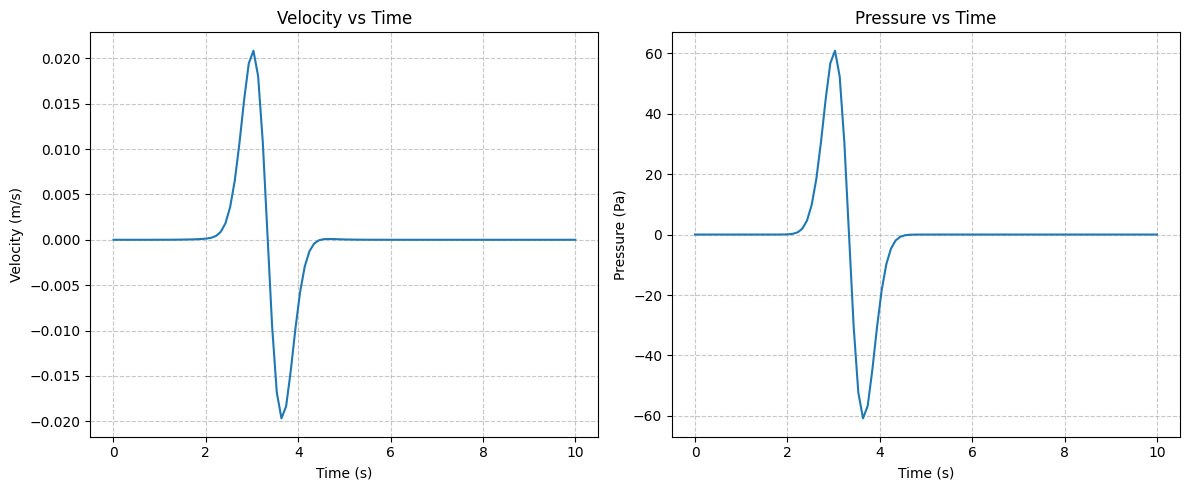

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = np.linspace(0, 10, 100)  # Time array from 0 to 10 seconds
r = 100  # Constant radius value
z = 0  # Constant z-value
c = 300  # Constant c-value

# Calculate velocity
velocity = test_velocity(t, r, z, c)[:,0]

# Calculate pressure (assuming a linear relationship for demonstration purposes)
pressure = test_pressure(t, r, z)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot velocity on the first subplot
ax1.plot(t, velocity)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Velocity (m/s)')
ax1.set_title('Velocity vs Time')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot pressure on the second subplot
ax2.plot(t, pressure)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pressure (Pa)')
ax2.set_title('Pressure vs Time')
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [4]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib

matplotlib.rcParams['animation.ffmpeg_path'] = "/opt/homebrew/bin/ffmpeg"

N = 100
pressure_array = np.zeros((N, N))
x_low, x_upper = -800, 800
y_low, y_upper = -800, 800
times = np.linspace(0,10,100)

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array, extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap='jet', origin='lower', vmin=-60, vmax=60)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t):
    for i in range(N):
        for j in range(N):
            x = x_low + (x_upper - x_low) * i / N
            y = y_low + (y_upper - y_low) * j / N

            pressure_array[j][i] = test_pressure(t, np.linalg.norm(np.array([x, y])), 0)

    im.set_array(pressure_array)
    ax.set_title(f'Pressure Distribution at t={t:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=times, 
                    interval=200)
plt.close()
HTML(ani.to_html5_video())

NameError: name 'HTML' is not defined

## 2.0 Using test problem as input for Mario's surface integral

## Mario's solution for pressure 

$$
p'(x, t) = - \int_S n_i (\rho v_i v_j + p_{ij}) * \frac{\partial G}{\partial x_i} dS(\bar{x}') + \int_S n_i (\rho v_i) * \frac{\partial G}{\partial t} dS (\bar{x}')
$$

Where:
- $x$ is the receiver location.
- $x'$ is the source location.

### Monopole term 

$$
\int n_i (\rho v_i) \frac{\partial G}{\partial t} dS \equiv \sum_k \frac{1}{4\pi r_k} \frac{\partial}{\partial \tau} [(\rho(v \cdot n_k))]_{\tau_k} dS_k
$$

The retarded time derivative can be calculated by finite differences. 

### Dipole term 

$$
-\int n_i (\rho v_i v_j + P_{ij}) \frac{\partial G}{\partial x_i}dS \equiv - \frac{1}{4 \pi} \nabla_x \cdot \int_S \frac{F(x')}{r} dS(x')
$$

where 

$$
\vec{F} = \vec{n} \cdot (\rho \vec{v}\vec{v} + P)
$$

For the dipole term, we break the divergence into a finite difference approximation.

$$
\nabla \cdot U \equiv \sum_{i=1}^d \frac{U_i(x + \Delta x \vec{e}_i) - U_i(x - \Delta x \vec{e}_i)}{2 \Delta x}

In [7]:
from helper_code.lighthill import compute_monopole_dipole_flux

N = 20 # number of points for integration
phi = np.linspace(0, 2 * np.pi, N)
theta = np.linspace(0, np.pi/2, N, endpoint=False)
times = np.linspace(0,10,100)

Theta, Phi = np.meshgrid(theta, phi, indexing='ij')

dphi = phi[1] - phi[0]
dtheta = theta[1] - theta[0]
a = 20 # radius of integration [m]

c0 = 300 # speed of sound [m/s]

dS = np.array(a**2 * np.sin(Theta) * dphi * dtheta).flatten()  # differential area element on the sphere

normals = np.array([np.sin(Theta.flatten()) * np.cos(Phi.flatten()), np.sin(Theta.flatten()) * np.sin(Phi.flatten()), np.cos(Theta.flatten())]).T
x_prime = np.array([np.cos(Phi.flatten()) * np.sin(Theta.flatten()) * a, np.sin(Phi.flatten()) * np.sin(Theta.flatten()) * a, np.cos(Theta.flatten()) * a]).T

x_obs = np.array([200, 0, 0])

M_mom_dt = np.zeros((len(times)))
D_div = np.zeros((len(times)))
p_t = np.zeros((len(times)))

M_mom_dt_array = np.zeros((len(times), N**2))
D_div_array = np.zeros((len(times), N**2))

for i, t in enumerate(times):
    M_mom_dt[i], D_div[i], M_mom_dt_array[i], D_div_array[i] = compute_monopole_dipole_flux(x_obs, t, x_prime, dS, normals, c0, times, test_rho, test_velocity, test_sigma)


    if i % 20 == 0:
        print(f"Computing pressure at time {t} s")

Computing pressure at time 0.0 s


TypeError: test_rho() takes 2 positional arguments but 3 were given